In [480]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

#import matplotlib

In [481]:
def logreg_auc(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target].values.ravel()
    logreg = linear_model.LogisticRegression()
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

def logreg_ll(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target].values.ravel()
    logreg = linear_model.LogisticRegression()
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    ll = log_loss(y, predictions)
    return(ll)

def next_best(current_variables,candidate_variables, target, basetable):
    best_auc = -1
    best_ll = 100000
    best_variable = None
    for v in candidate_variables:
        #auc_v = logreg_auc(current_variables + [v], target, basetable)
        ll_v = logreg_ll(current_variables + [v], target, basetable)
        #if auc_v >= best_auc:
        #    best_auc = auc_v
        if ll_v <= best_ll:
            best_ll = ll_v
            best_variable = v
    print(best_ll)
    return best_variable

In [482]:


def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
                                   
    # Calculate size and target incidence for each group
    #def my_agg(x):
    #    names = {
    #        'Incidence': x[target].mean(),
    #        'Size':  x[target].count()}
    #    return pd.Series(names, index=['Incidence', 'Size'])
    
    #groups.groupby(target).apply(my_agg)
    pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()
    
    # Return the predictor insight graph table
    return pig_table

def plot_pig(pig_table,variable):
    
    # Plot formatting
    plt.ylabel("Size", rotation = 0,rotation_mode="anchor", ha = "right" )
    
    # Plot the bars with sizes 
    pig_table["Size"].plot(kind="bar", width = 0.5, color = "lightgray", edgecolor = "none") 
    
    # Plot the incidence line on secondary axis
    pig_table["Incidence"].plot(secondary_y = True)
    
    # Plot formatting
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table)-0.5])
    plt.ylabel("Incidence", rotation = 0, rotation_mode="anchor", ha = "left")
    
    # Show the graph
    plt.show()
    

In [483]:
data = pd.read_csv("data/data.csv")

In [484]:
data.head()

,Unnamed: 0,YEAR,SERIAL,DUID,PID,MEPSID,PANEL,PSUANN,STRATANN,PSUPLD,...,HEARTCONEV,HYPERTENEV,STROKEAGE,STROKEV,HYPERTENAGE,CHEARTDIAGE,HEARTATTAGE,CHOLHIGHAGE,DIABETICAGE,HPTOTNIGHT
0,1,2010,1,10007,101,1000710115,15,2,1024,2.0,...,1,2,0,1,24,96,96,27,96,0
1,2,2010,1,10007,102,1000710215,15,2,1024,2.0,...,1,1,0,1,96,96,96,96,96,0
2,3,2010,1,10007,103,1000710315,15,2,1024,2.0,...,0,0,0,0,96,96,96,96,96,0
3,4,2010,1,10007,104,1000710415,15,2,1024,2.0,...,0,0,0,0,96,96,96,96,96,0
4,5,2010,2,10008,101,1000810115,15,1,1021,1.0,...,1,1,0,1,96,96,96,96,96,0


In [485]:
data.dtypes

Unnamed: 0       int64
YEAR             int64
SERIAL           int64
DUID             int64
PID              int64
MEPSID           int64
PANEL            int64
PSUANN           int64
STRATANN         int64
PSUPLD         float64
STRATAPLD      float64
PANELYR          int64
RELYR            int64
PERNUM           int64
PERWEIGHT      float64
SAQWEIGHT      float64
DIABWEIGHT     float64
AGE              int64
SEX              int64
MARSTAT          int64
BIRTHYR          int64
EDUC             int64
EDUCYR         float64
HIDEG          float64
INCTOT         float64
FTOTVAL        float64
DIABETICEV       int64
HEARTATTEV       int64
HEARTCONEV       int64
HYPERTENEV       int64
STROKEAGE        int64
STROKEV          int64
HYPERTENAGE      int64
CHEARTDIAGE      int64
HEARTATTAGE      int64
CHOLHIGHAGE      int64
DIABETICAGE      int64
HPTOTNIGHT       int64
dtype: object

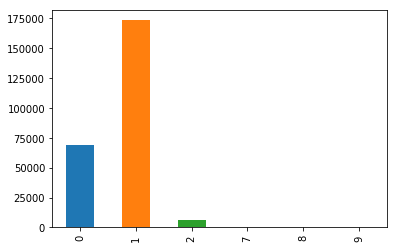

In [486]:
target_variable = "HEARTATTEV"
candidate_variables = []
data[target_variable].value_counts().sort_index().plot("bar");

In [487]:
data[target_variable].isna().sum()

0

In [488]:
#binary classification of target variable
#remove all data rows with unknown target variable
data.drop(data[-data[target_variable].isin([1, 2])].index, inplace = True)
data.loc[data[target_variable] == 1,target_variable] = 0
data.loc[data[target_variable] == 2,target_variable] = 1
data = data.reset_index(drop = True)

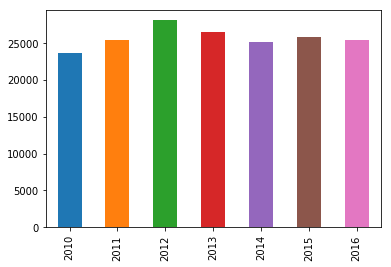

In [489]:
data['YEAR'].value_counts().sort_index().plot(kind='bar');

In [490]:
data["YEAR"].isna().sum()

0

In [491]:
candidate_variables.extend(["YEAR"])

In [492]:
#BIRTHYR more complete as for variable AGE all ages > 85 are set as 85 and there are missing ages (99)
#check that BIRTHYR consistent
data['test'] = data['YEAR'] - data['BIRTHYR'] - data['AGE']
data.loc[data['AGE'] > 85, 'test'] = 0
data.loc[abs(data['test'])>1, 'test']

Series([], Name: test, dtype: int64)

In [493]:
data["BIRTHYR"].isna().sum()

0

In [494]:
#recalculate age
data['AGE'] = data['YEAR'] - data['BIRTHYR']
data = data.drop(['test'],axis=1)
candidate_variables.extend(["AGE"])

In [495]:
#PERWEIGHT technical variable to reweight samples 
data["PERWEIGHT"].describe()

count    179785.000000
mean       9416.623627
std        8351.204369
min           0.000000
25%        3784.611328
50%        6900.357910
75%       12644.689453
max      102133.750000
Name: PERWEIGHT, dtype: float64

In [496]:
sum(data['DIABWEIGHT'] != 0)

15100

In [497]:
data['SEX'].unique()

array([1, 2], dtype=int64)

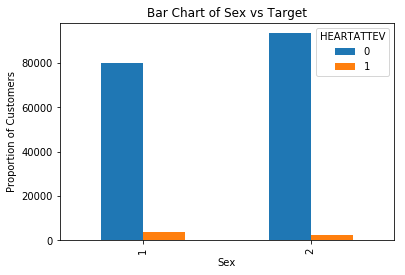

In [498]:
pd.crosstab(data.SEX,data[target_variable]).plot(kind='bar')
plt.title('Bar Chart of Sex vs Target')
plt.xlabel('Sex')
plt.ylabel('Proportion of Customers')
plt.savefig('sex_vs_tgt')

In [499]:
data["SEX"].isna().sum()

0

In [500]:
candidate_variables.extend(["SEX"])

In [501]:
data['MARSTAT'].dtype

dtype('int64')

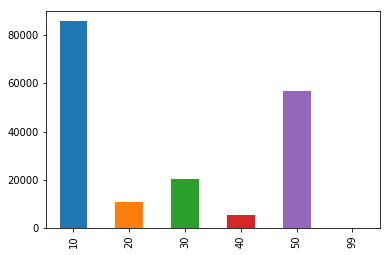

In [502]:
data['MARSTAT'] = data['MARSTAT'].astype('object')
data['MARSTAT'].value_counts().sort_index().plot("bar");

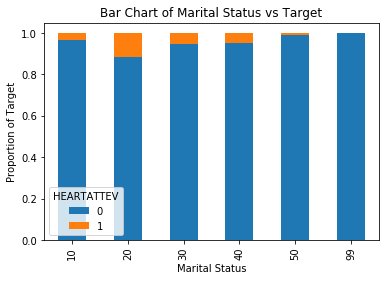

In [503]:
table=pd.crosstab(data.MARSTAT,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Marital Status vs Target')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Target')
plt.savefig('marital_vs_tgt')

In [504]:
data["MARSTAT"].isna().sum()

0

In [505]:
candidate_variables.extend(["MARSTAT"])

In [506]:
data['EDUC'].unique()

array([604, 401, 603, 601, 999, 301, 201, 302, 203, 500, 202, 204, 103,
       109, 996, 108, 106, 101, 105, 107, 104, 102, 998, 997,   0, 402,
       403, 602, 200, 100, 600, 300], dtype=int64)

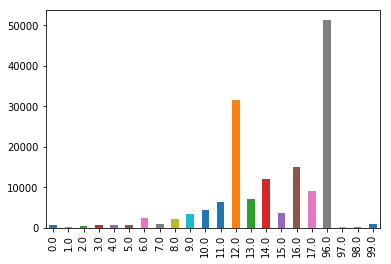

In [507]:
data['EDUCYR'].value_counts().sort_index().plot("bar");
#review if correlation high enough to just use one of two

In [508]:
data["EDUCYR"].isna().sum()

26499

In [509]:
# regroup different types of unknown. Treat variable as numeric therefore keep as missing
# integer variable canont handle empty, keep as float
data.loc[data['EDUCYR'].isin([96, 97, 98, 99]),'EDUCYR'] = np.nan

In [510]:
data["EDUCYR"].isna().sum()

79035

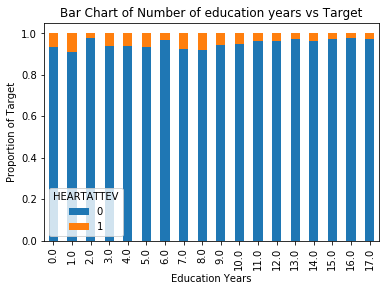

In [511]:
table=pd.crosstab(data.EDUCYR,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Number of education years vs Target')
plt.xlabel('Education Years')
plt.ylabel('Proportion of Target')
plt.savefig('educyr_vs_tgt')

In [512]:
candidate_variables.extend(["EDUCYR"])

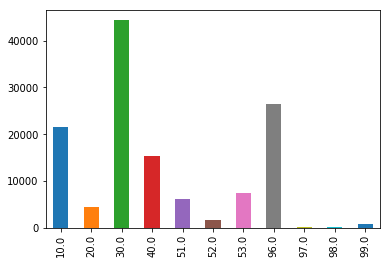

In [513]:
data['HIDEG'].value_counts().sort_index().plot("bar");

In [514]:
data["HIDEG"].isna().sum()

51560

In [515]:
# regroup different types of unknown. Treat as categorical variable, therefore replace with 99
data.loc[data['HIDEG'].isna(), 'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype(int)
data.loc[data['HIDEG'].isin([96, 97, 98, 99]),'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype('object')

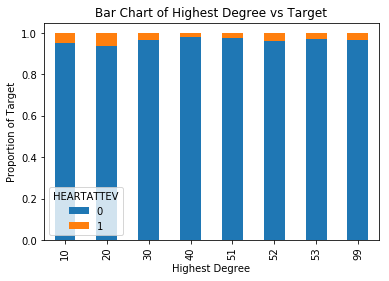

In [516]:
table=pd.crosstab(data.HIDEG,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Highest Degree vs Target')
plt.xlabel('Highest Degree')
plt.ylabel('Proportion of Target')
plt.savefig('hideg_vs_tgt')

In [517]:
data["HIDEG"].isna().sum()

0

In [518]:
candidate_variables.extend(["HIDEG"])

In [519]:
data["INCTOT"].describe()

count    179785.000000
mean      29824.530645
std       33950.942183
min     -204643.000000
25%        8088.000000
50%       20000.000000
75%       40000.000000
max      731652.960000
Name: INCTOT, dtype: float64

In [520]:
data["INCTOT"].isna().sum()

0

In [521]:
data["FTOTVAL"].describe()

count    179785.000000
mean      61156.177518
std       57114.272213
min     -258220.000000
25%       21855.000000
50%       45000.000000
75%       82930.000000
max      731653.000000
Name: FTOTVAL, dtype: float64

In [522]:
data["FTOTVAL"].isna().sum()

0

In [523]:
candidate_variables.extend(["FTOTVAL"])

In [524]:
data['DIABETICEV'].value_counts()

1    160998
2     18755
9        27
7         5
Name: DIABETICEV, dtype: int64

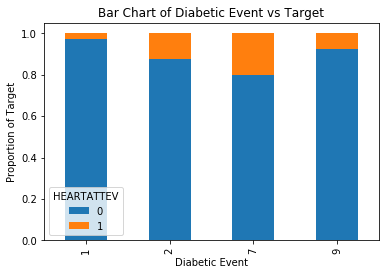

In [525]:
table=pd.crosstab(data.DIABETICEV,data[target_variable])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Bar Chart of Diabetic Event vs Target')
plt.xlabel('Diabetic Event')
plt.ylabel('Proportion of Target')
plt.savefig('hideg_vs_tgt')

In [526]:
data.loc[data['DIABETICEV'].isin([1, 7, 9]),'DIABETICEV'] = 0
data.loc[data['DIABETICEV'] == 2,'DIABETICEV'] = 1

In [527]:
data["DIABETICEV"].isna().sum()

0

In [528]:
candidate_variables.extend(["DIABETICEV"])

In [529]:
candidate_variables

['YEAR', 'AGE', 'SEX', 'MARSTAT', 'EDUCYR', 'HIDEG', 'FTOTVAL', 'DIABETICEV']

In [530]:
#candidate_variables = ['YEAR', 'PERWEIGHT', 'SAQWEIGHT', 'AGE', 'SEX', 'MARSTAT', 'EDUCYR', 'HIDEG', 'INCTOT', 'FTOTVAL', 'DIABETICEV']

In [531]:
train = data[candidate_variables]
Label = data[target_variable]

In [532]:
train.shape

(179785, 8)

In [533]:
cat_features = [train.columns[i] for i, j in enumerate(train.dtypes) if (j == "object" or j == "bool")]
numeric_features = [train.columns[i] for i, j in enumerate(train.dtypes) if j in ["int64", "float64"]]

In [534]:
cat_features

['MARSTAT', 'HIDEG']

In [535]:
numeric_features

['YEAR', 'AGE', 'SEX', 'EDUCYR', 'FTOTVAL', 'DIABETICEV']

def check_discretize(basetable, variable, threshold):
    return(len(basetable.groupby(variable))>threshold)
threshold = 5
number_bins = 5
for variable in numeric_features:
    if check_discretize(basetable, variable, threshold):
        new_variable = "disc" + variable
        basetable[new_variable] = pd.qcut(basetable[variable], number_bins)

# Dummy variables

In [536]:
train_cat = train[cat_features]
for var in cat_features:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train_cat[var], prefix=var)
    data1=train_cat.join(cat_list)
    train_cat=data1
train_cat.head()

,MARSTAT,HIDEG,MARSTAT_10,MARSTAT_20,MARSTAT_30,MARSTAT_40,MARSTAT_50,MARSTAT_99,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HIDEG_99
0,10,53,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10,30,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,10,52,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,10,51,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,50,99,0,0,0,0,1,0,0,0,0,0,0,0,0,1


# Missing values

In [537]:
train_num = train[numeric_features]
# check variables that are missing
for j in range(train_num.values.shape[1]):
    vec = train_num.values[:,j]
    mask = np.isfinite(vec)
    if np.sum(~mask) > 0:
        print(j, train_num.columns[j])
        print(np.sum(~mask))

3 EDUCYR
79035


In [538]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(train_num)
train_num_imp= imp.transform(train_num)
train_num = pd.DataFrame(train_num_imp, columns = train_num.columns)

In [539]:
train_cat.head()

,MARSTAT,HIDEG,MARSTAT_10,MARSTAT_20,MARSTAT_30,MARSTAT_40,MARSTAT_50,MARSTAT_99,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HIDEG_99
0,10,53,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10,30,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,10,52,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,10,51,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,50,99,0,0,0,0,1,0,0,0,0,0,0,0,0,1


# Dataset

In [540]:
train = pd.concat([train_num, train_cat], axis=1, sort=True)
train = train.drop(['MARSTAT', 'HIDEG'], axis=1)

# Train-test

In [541]:
X_train, X_val, y_train, y_val = train_test_split(train, Label, random_state=0)

In [542]:
y_train.value_counts().sort_index()

0    130168
1      4670
Name: HEARTATTEV, dtype: int64

In [543]:
y_val.value_counts().sort_index()

0    43288
1     1659
Name: HEARTATTEV, dtype: int64

# K-fold

In [544]:
num_folds = 3
num_instances = len(train)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)

# Logistic Regression - Forward selection

In [545]:
# remove one category (null)
X_train = X_train.drop(['MARSTAT_99', 'HIDEG_99'], axis=1)
basetable = pd.concat([X_train, y_train], axis=1)
variables = list(X_train.columns.values)

In [546]:
basetable.head()

,YEAR,AGE,SEX,EDUCYR,FTOTVAL,DIABETICEV,MARSTAT_10,MARSTAT_20,MARSTAT_30,MARSTAT_40,MARSTAT_50,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HEARTATTEV
87489,2013.0,23.0,1.0,12.0,1500.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0
71069,2012.0,23.0,2.0,12.0,21000.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0
121339,2014.0,60.0,2.0,12.0,45488.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
43066,2011.0,38.0,1.0,13.0,26030.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0
160043,2016.0,69.0,2.0,6.0,29910.0,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [547]:
X = basetable.drop(target_variable, axis=1)
y = basetable[target_variable]#.values.ravel()
logreg = linear_model.LogisticRegression()
logreg.fit(X, y)
predictions = logreg.predict_proba(X)[:,1]
auc = roc_auc_score(y, predictions)
auc

0.8289571855550995

In [548]:
max_number_variables = 6
number_iterations = min(max_number_variables, len(variables))
current_variables = []
for i in range(0,number_iterations):
    next_var = next_best(current_variables, variables, [target_variable], basetable)
    current_variables = current_variables + [next_var]
    variables.remove(next_var)
print(current_variables)

0.12771251416638413
0.12452665580711784
0.12273734101816432
0.12248772658108997
0.12229617518664818
0.12208784938850932
['AGE', 'DIABETICEV', 'SEX', 'HIDEG_20', 'MARSTAT_10', 'MARSTAT_50']


In [549]:
logreg.fit(basetable[current_variables],basetable[target_variable])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [550]:
predictions = logreg.predict_proba(X_val[current_variables])
auc = roc_auc_score(y_val, predictions[:,1])
logloss = log_loss(y_val, predictions[:,1])

In [551]:
print(auc)
print(logloss)

0.8474033107274056
0.1279691034505949


C:\Users\Karsten\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


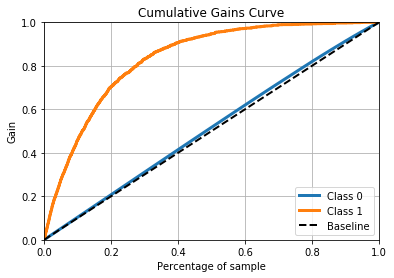

In [552]:
skplt.metrics.plot_cumulative_gain(y_val, predictions)
plt.show()

In [553]:
np.exp(logreg.coef_)

array([[1.06396517, 2.71420949, 0.46313653, 1.93196372, 0.70500164,
        0.63658803]])

In [554]:
pig_tables = {}
for variable in current_variables:
    # Create a predictor insight graph table
    pig_table = create_pig_table(basetable, target_variable, variable)
    # Add the table to the dictionary
    pig_tables[variable] = pig_table

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [555]:
print(pig_tables["DIABETICEV"])

   DIABETICEV  Incidence    Size
0         0.0   0.024397  120792
1         1.0   0.122668   14046


KeyError: 'DIABETICEV'

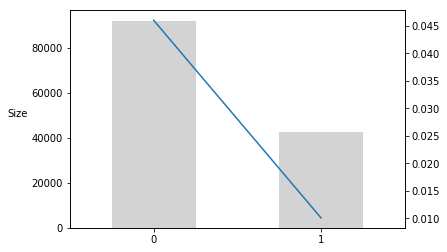

In [556]:
plot_pig(pig_table, "DIABETICEV")

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,basetable[current_variables])
result=logit_model.fit()
print(result.summary2())

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, logreg.predict(X_val[current_variables]))
print(confusion_matrix)

# Logistic Regression - Grid search

In [ ]:
param_grid_logreg = {
    'C': [0.3, 1, 3]
}

In [ ]:
logreg2 = linear_model.LogisticRegression()
grid_logreg = GridSearchCV(logreg2, param_grid_logreg, cv=kfold, scoring='neg_log_loss')
grid_logreg.fit(train, Label)

In [ ]:
grid_logreg.best_estimator_

In [ ]:
means = grid_logreg.cv_results_['mean_test_score']
stds = grid_logreg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_logreg.cv_results_['params']):
   print("%0.3f (+/-%0.03f) for %r"
   % (mean, std * 2, params))

In [ ]:
grid_logreg.best_estimator_.coef_